In [460]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [461]:
# Neural nets are massive mathematical expressions so data structures are needed to store these expressions
# -----------------------------------------------------------------------------------------------------------------------------------------------
#   Simple value class that stores a single instance of any data type
class value:

  def __init__(self, data, _children = (), _operation = '', label = ''):
    self.data = data # The data stored
    self.grad = 0.0 # The gradient of the data
    self._backward = lambda: None # The backward pass function
    self._prev = set(_children) # The other value objects that were operated on, to produce this one
    self._op = _operation # The operation that was performed to produce this value
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, value) else value(other)
    out = value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other): # self + (- other) = self - other
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, value) else value(other)
    out = value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # allows other + value
    return self + other

  def __rsub__(self, other): # allows other + value
    return (-self) + other

  def __rmul__(self, other): # other * self - reroutes to __mul__ if definition available
    return self * other

  def __truediv__(self, other): # self / other = self * (1/other) = self * other**-1
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad # dy/dx of tanh(x) = 1-tanh^2(x)
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    e = (math.exp(x))
    out = value(e, (self, ), 'exp') # <--We have the value for e^x here

    def _backward():
      self.grad = out.data * out.grad # dy/dx of e^x = e^x
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad = (other * self.data**(other - 1.0)) * out.grad # dy/dx of e^x = e^x
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
     if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [462]:
from graphviz import Digraph

In [463]:
# Functions defined by Andrej Karpathy to visualize the value operations
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [464]:
import random

In [465]:
class Neuron:
  def __init__(self, nin):
    self.w = [value(random.uniform(-1,1)) for _ in range(nin)] # Weight between -1 to 1 for every input into Neuron
    self.b = value(random.uniform(-1,1)) # Bias, between -1 to 1, of Neuron

  def __call__(self, x): # Lets object (not just constructor) be called like a function - i.e. with an argument
    # w.x + b
    # Activation --------------------------------------------------------------------------------------------------------
    wx_pairs = zip(self.w, x) # Tuple of pairs of iterators w_i and corresponding input (also an iterator) x_i
    act = sum((wi*xi for wi,xi in wx_pairs), self.b) # Dot product of w.x
    # -------------------------------------------------------------------------------------------------------------------
    out = act.tanh() # Activation function
    return out

  def parameters(self):
    return (self.w + [self.b])

n = Neuron(2)

# **Multi Layer Perceptron**

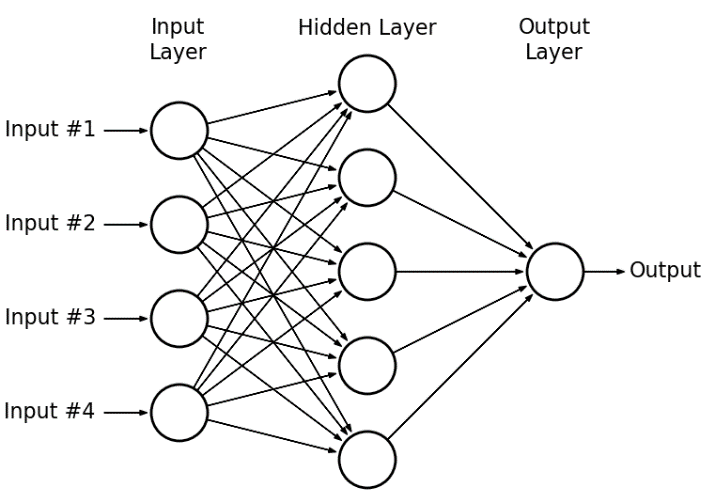

In [466]:
# Each MLP Layer is a list of Neurons containing n (neurons) * i (inputs/neuron) and n outputs
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps) # .extend adds all items from another iterable (like a set or tuple or list even) individually, at the end of the current l
    return params

n = Layer(2,3)

In [467]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # List of layer sizes including input layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # Create layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # Pass input through each layer
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters()) # Collect parameters from all layers
        return params

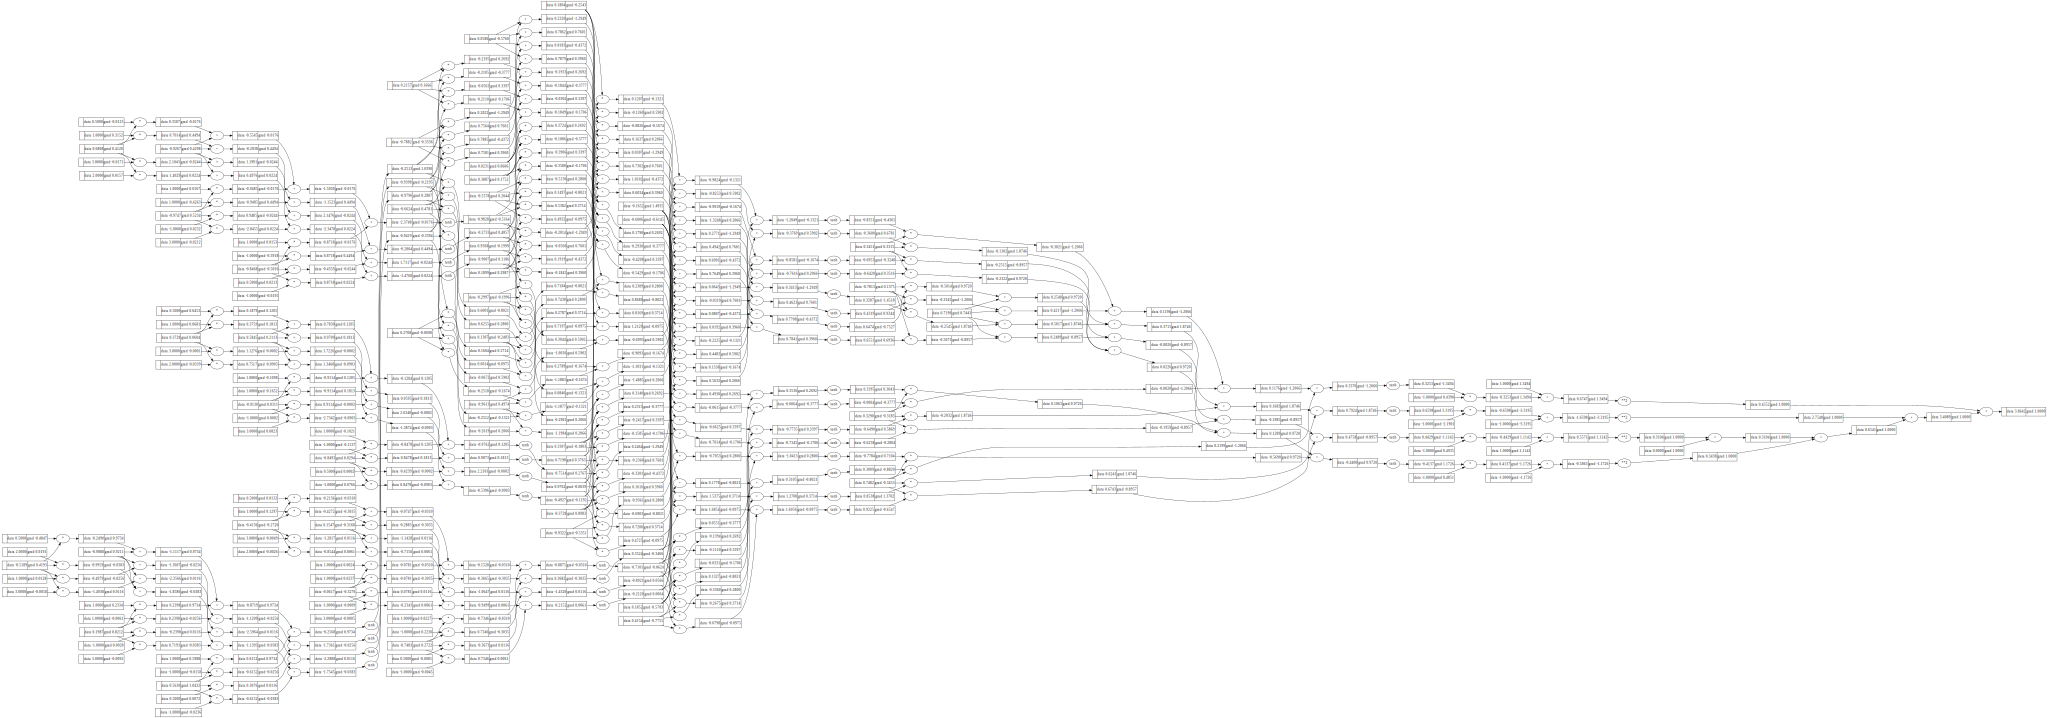

In [484]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # Expected targets

ypred = [n(x) for x in xs]

mlp = MLP(3, [4, 4, 1]) # Define the MLP here

# forward pass
ypred = [mlp(x) for x in xs] # Use mlp to get predictions
loss = sum((y - yhat)**2 for y, yhat in zip(ys, ypred)) # Corrected variable name

# backward pass
for p in mlp.parameters(): # Zero-grad parameters of the entire MLP
   p.grad = 0.0
loss.backward()

# update weights and biases (gradient descent)
for p in mlp.parameters():
  p.data += -0.05*p.grad

draw_dot(loss)

In [482]:
# Training loop
mlp = MLP(3, [4, 4, 1]) # Define the MLP here

for k in range(20):

  # forward pass
  ypred = [mlp(x) for x in xs] # Use mlp to get predictions
  loss = sum((y - yhat)**2 for y, yhat in zip(ys, ypred)) # Corrected variable name

  # backward pass
  for p in mlp.parameters(): # Zero-grad parameters of the entire MLP
    p.grad = 0.0
  loss.backward()

  # update weights and biases (gradient descent)
  for p in mlp.parameters():
    p.data += -0.05*p.grad

  print(f"Epoch {k}, Loss: {loss.data}")

Epoch 0, Loss: 7.293382935804028
Epoch 1, Loss: 5.913013270002729
Epoch 2, Loss: 2.5081269837427937
Epoch 3, Loss: 1.7514397298665032
Epoch 4, Loss: 1.1180304920005502
Epoch 5, Loss: 0.6695971738238384
Epoch 6, Loss: 0.4141747861472458
Epoch 7, Loss: 0.2816851870696633
Epoch 8, Loss: 0.20758209374944248
Epoch 9, Loss: 0.16195415199112273
Epoch 10, Loss: 0.13163606467053265
Epoch 11, Loss: 0.11027089619243775
Epoch 12, Loss: 0.09451493365433997
Epoch 13, Loss: 0.08247327007119566
Epoch 14, Loss: 0.07300340400613566
Epoch 15, Loss: 0.0653803580974121
Epoch 16, Loss: 0.05912415651210291
Epoch 17, Loss: 0.05390551692251318
Epoch 18, Loss: 0.04949161884431299
Epoch 19, Loss: 0.04571353398034582


In [483]:
ypred # Closer to expected output (1, -1, -1, 1)

[value(data=0.8854925417767858),
 value(data=-0.969806835902543),
 value(data=-0.8631129505318895),
 value(data=0.8861936534225626)]